In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import re
import pickle
import sklearn
import sys
import string

from datetime import datetime
from scipy import stats

from sklearn.externals import joblib
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.delicious_t140
%aimport src.helpers.labels
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [4]:
from src.features.delicious_t140 import clean_text_delicious
from src.data.delicious_t140 import get_sample_from_cache
from src.helpers.labels import truncate_labels
from src.utils.metrics import ranking
from src.utils.dataframes import sample_rows
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/delicious-topics/")
DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140"
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/delicious-t140/")
OUTPUT_FILE = 'output-topic-distances-'+ datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.txt'

# CONFIGS

SEED= 42

MAX_NB_WORDS = 500

# for sampling
MIN_TAG_DF = 10
SAMPLE_FRAC=20

# CONFIGS
NB_NEIGHBOURS = 1
DISTANCE_METRIC= lambda a,b: stats.entropy(a,b)
STOP_WORDS='english' # using stopwords since most people using LDA do this
NB_COMPONENTS = [50,100,200,300]

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = get_sample_from_cache(INTERIM_DATA_ROOT,SAMPLE_FRAC)

In [8]:
docs_df.head(1)

,filename,filetype,hash,tags,url,num_users,num_tags,contents
0,26313806abe42032de4f612017738426.html,html,26313806abe42032de4f612017738426,"tutoriel,multimedia,english,screencasts,videos...",http://screencasts.ubuntu.com/,228,23,"Ubuntu Screencasts @import ""/misc/drupal.css""..."


In [9]:
len(docs_df)

28743

In [10]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))
labels = truncate_labels(labels,MIN_TAG_DF)

In [11]:
np.random.seed(SEED)

mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['contents'].values
indices = np.arange(len(data))
np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 3305 
total number of train documents: 24432
total number of validation documents: 4311


In [12]:
vect = TfidfVectorizer(max_features=MAX_NB_WORDS)
# it's ok to fit in the whole data since this is not training a model
vect.fit(data)

X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)

In [13]:
%%time

lda = dict()

for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    
    cache_path = INTERIM_DATA_ROOT+"/lda-NBCOMPS={}NBWORDS={}SEED={}.p".format(nb_comp,MAX_NB_WORDS,SEED)
    
    if os.path.isfile(cache_path):
        lda[nb_comp]=joblib.load(open(cache_path,"rb"))
    else:
        lda[nb_comp] = LatentDirichletAllocation(n_components=nb_comp, learning_method='online')
        lda[nb_comp].fit(X_train_vect)
        joblib.dump(lda[nb_comp],open(cache_path,"wb"))

nb_comp=50
nb_comp=100
nb_comp=200
nb_comp=300
CPU times: user 36min 39s, sys: 1h 39min 23s, total: 2h 16min 3s
Wall time: 18min 39s


In [14]:
def train_and_score(nb_comp):
    nbrs = NearestNeighbors(n_neighbors=NB_NEIGHBOURS, metric=DISTANCE_METRIC)
    
    lda_model = lda[nb_comp]
    
    # train
    X_train = lda_model.transform(X_train_vect)
    X_val = lda_model.transform(X_val_vect)
    
    nbrs.fit(X_train)
    
        
    Y_pred_val = []

    # distance matrix shape: (num_validation_documents, k)
    # indices matrix shape: (num_validation_documents, k)
    distances_matrix_val, indices_matrix_val = nbrs.kneighbors(X_val)
    
    neighbour_labels_tensor_val = Y_train[indices_matrix_val]    
   
    # for every validation document do
    for i in range(distances_matrix_val.shape[0]):
        # these are the labels from the neighbours of test document i
        # shape: (k, num_tags)
        neighbor_labels = neighbour_labels_tensor_val[i,:,:]
        
        # these are the distances from test document i to the nearest neighbours
        # shape: (k, )
        distances_to_neighbors = distances_matrix_val[i]

        # sum the contributions from all neighbors, for all tags
        # no need to normalize because we're only interested in the order
        y_preds = neighbor_labels.sum(axis=0)
                    
        Y_pred_val.append(y_preds)

    Y_pred_val = np.array(Y_pred_val)
            
    ks = [1,2,3,4,5,6,7,8,9,10]
    
    # k is the number of neighbors so let's use at_k
    for at_k in ks:
        print("validation micro-F1 @{}: {}".format(at_k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True))) 

    print('')  

In [15]:
for nb_comp in NB_COMPONENTS:
    print('nb_comp={}'.format(nb_comp))
    train_and_score(nb_comp)

nb_comp=50
validation micro-F1 @1: 0.12238675958188153
validation micro-F1 @2: 0.1390028059572631
validation micro-F1 @3: 0.14140978659193792
validation micro-F1 @4: 0.1394044022442814
validation micro-F1 @5: 0.13529996972187378
validation micro-F1 @6: 0.130866784694873
validation micro-F1 @7: 0.12681564245810056
validation micro-F1 @8: 0.12172208152928682
validation micro-F1 @9: 0.11783254099155914
validation micro-F1 @10: 0.1137606650623496

nb_comp=100
validation micro-F1 @1: 0.1305290546400694
validation micro-F1 @2: 0.14140978659193792
validation micro-F1 @3: 0.14620511717910126
validation micro-F1 @4: 0.14211065021817595
validation micro-F1 @5: 0.13924378453038674
validation micro-F1 @6: 0.13645533141210375
validation micro-F1 @7: 0.13220685173150126
validation micro-F1 @8: 0.12834776001953707
validation micro-F1 @9: 0.1247915710108504
validation micro-F1 @10: 0.12062689365041306

nb_comp=200
validation micro-F1 @1: 0.1513722126929674
validation micro-F1 @2: 0.1535496305814327
va

In [16]:
feats_50 = [
0.12238675958188153,0.1390028059572631,
  0.14140978659193792,0.1394044022442814,
0.13529996972187378,0.130866784694873,
0.12681564245810056, 0.12172208152928682,
0.11783254099155914,0.1137606650623496
]

feats_100 = [
0.1305290546400694, 0.14140978659193792,
0.14620511717910126,   0.14211065021817595,
0.13924378453038674,0.13645533141210375,
0.13220685173150126,0.12834776001953707,
0.1247915710108504,0.12062689365041306
]

feats_200 = [
0.1513722126929674, 0.1535496305814327,
0.1548009701811956,0.14849412143662424,
0.14556716995741387,0.14274430961441803,
0.13974848970533843,0.13563261886098874,
0.13106936416184972,0.1272806255430061    
]

feats_300 = [
0.1410090556274256,0.15018236429950654,
0.153483723586522,0.1535496305814327,
0.15049980694152473,0.14593935918572146,
0.1421535430647048,0.13724378190067243,
0.1323288726292481,0.12874381456723674
]


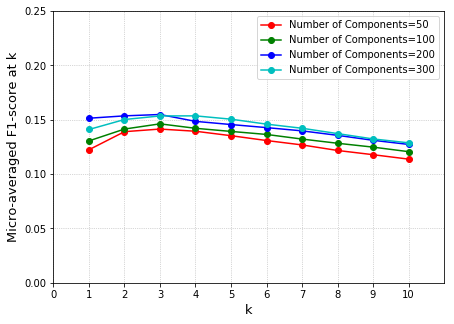

In [17]:
plt.clf()
ax = plt.gca()

ks = range(1, 11)

ax.plot(ks, feats_50, 'ro-', label='Number of Components=50')

ax.plot(ks, feats_100, 'go-', label='Number of Components=100')

ax.plot(ks, feats_200, 'bo-', label='Number of Components=200')

ax.plot(ks, feats_300, 'co-', label='Number of Components=300')

ax.set_xlim(0, 11)
ax.set_ylim(0, 0.25)
ax.set_xlabel('k', fontsize=13)

ax.set_ylabel('Micro-averaged F1-score at k', fontsize=13)

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 0.26, 0.05))
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)
plt.gcf().set_size_inches(7,5)
ax.legend()
plt.show()